<a href="https://colab.research.google.com/github/drewwint/Dartbrains_code/blob/main/7_Group_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Analysis

In fMRI analysis, we are primarily interested in making inferences about how the brain processes information that is fundamentally similar across all brains even for people that did not directly participate in our study. This requires making inferences about the magnitude of the population level brain response based on measurements from a few randomly sampled participants who were scanned during our experiment.

In this tutorial, we will cover how we go from modeling brain responses in each voxel for a single participant to making inferences about the group. We will cover the following topics:

- Mixed Effects Models

- How to use the summary statistic approach to make inferences at second level

- How to perform many types of inferences at second level with different types of design matrics

Let’s start by watching an overview of group statistics by Tor Wager.

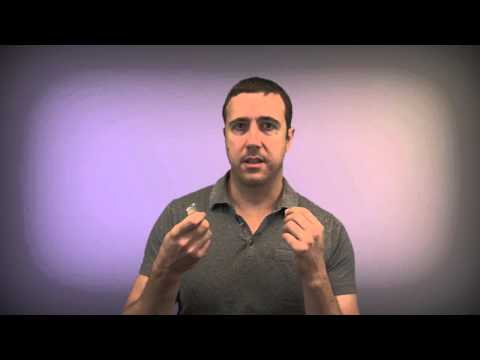

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('__cOYPifDWk')

## Hierarchical Data Structure

We can think of the data as being organized into a hierarchical structure. For each brain, we are measuring BOLD activity in hundreds of thousands of cubic voxels sampled at about 0.5Hz (i.e., TR=2s). Our experimental task will have many different trials for each condition (seconds), and these trials may be spread across multiple scanning runs (minutes), or entire scanning sessions (hours). We are ultimately interested in modeling all of these different scales of data to make an inference about the function of a particular region of the brain across the group of participants we sampled, which we would hope will generalize to the broader population.

In the past few notebooks, we have explored how to preprocess the data to reduce noise and enhance our signal and also how we can estimate responses in each voxel to specific conditions within a single participant based on convolving our experimental design with a canonical hemodynamic response function (HRF). Here we will discuss how we combine these brain responses estimated at the first-level in a second-level model to make inferences about the group.



## Modeling Mixed Effects

Let’s dive deeper into how we can model both random and fixed effects using multi-level models by watching another video by Tor Wager.

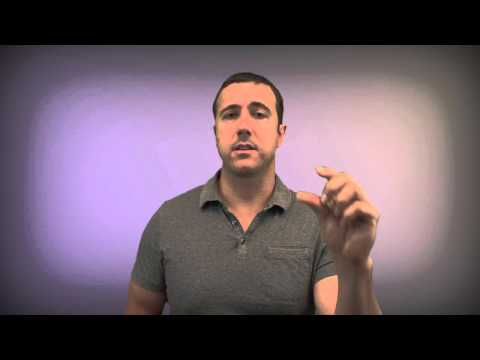

In [2]:
YouTubeVideo('-abMLQSjMSI')

Most of the statistics we have discussed to this point have assumed that the data we are trying to model are drawn from an identical distribution and that they are independent of each other. For example, each group of participants that complete each version of our experiment are assumed to be random sample of the larger population. However, if there was some type of systematic bias in our sampling strategy, our group level statistics would not necessarily reflect a random draw from the population-level Gaussian distribution. However, as should already be clear from the graphical depiction of the hierarchical structure of our data above, our data are not always independent. For example, we briefly discussed this in the GLM notebook, but voxel responses within the same participant are not necessarily independent as there appears to be a small amount of autocorrelation in the BOLD response. This requires whitening the data to meet the independence assumption. What is clear from the hierarchy is that all of the data measured from one participant are likely to be more similar to each other than another participant. In fact, it is almost always the case that the variance within a subject $\sigma^2_{within}$ is almost always smaller than the variance across participants $\sigma^2_{between}$. If we combined all of the data from all participants and treated them as if they were independent, we would likely have an inflated view of the group effect (this was historically referred to as a “fixed effects group analysis”).

This problem has been elegantly solved in statistics in a class of models called mixed effects models. Mixed effects models are an extension of regression that allows data to be structured into groups and coefficients to vary by groups. They are referred to differently in different scientific domains, for example they may be referred to as multilevel, hierarchical, or panel models. The reason that this framework has been found to be useful in many different fields, is that it is particularly well suited for modeling clustered data, such as students in a classroom and also longitudinal or repeated data, such as within-subject designs.

The term “mixed” comes from the fact that these models are composed of both fixed and random effects. Fixed effects refer to parameters describing the amount of variance that a feature explains of an outcome variable. Fixed factors are often explicitly manipulated in an experiment and can be categorical (e.g., gender) or continuous (e.g., age). We assume that the magnitude of these effects are fixed in the population, but that the observed signal strength will vary across sessions and subjects. This variation can be decomposed into different sources of variance, such as: - Measurement or Irreducible Error - Response magnitude that varies randomly across subjects. - Response magnitude that varies randomly across different elicitations (e.g., trials or sessions).

Modeling these different sources of variance allows us to have a better idea of how generalizable our estimates might be to another participant or trial.

As an example, imagine if we were interested if there were any gender differences between the length of how males and females cut their hair. We might sample a given individual several times over the course of a couple of years to get an accurate measurement of how long they keep their hair. These samples are akin to trials and will give us a way to represent the overall tendency of the length an individual keeps their hair in the form of a distribution. Narrow distributions mean that there is little variability in the length of the hair at each measurement, while wider distributions indicate more variation in the hair length across time. Of course, we are most interested not in the length of how an individual cuts their hair, but rather how many individuals from the same group cut their hair. This requires measuring multiple participants, who will all vary randomly around some population level hair length parameter. We are interested in modeling the true fixed effect of what the population parameter is for hair length, and specifically, whether this differs across gender. The variation in measurements within an individual and across individuals will reflect some degree of randomness that we need to account for in order to estimate a parameter that will generalize beyond the participants we measured their hair, but to new participants.

Poldrack, Mumford, & Nichols (2011)

In statistics, it is useful to distinguish between the model used to describe the data, the method of parameter estimation, and the algorithm used to obtain them.

Let’s now watch a video by Martin Lindquist to learn more about the way these models are estimated.

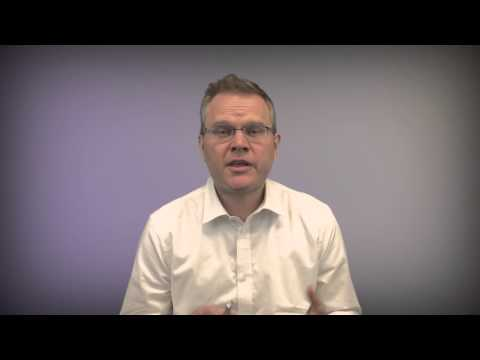

In [3]:
YouTubeVideo('-yaHTygR9b8')

## First Level - Single Subject Model

In fMRI data analysis, we often break analyses into multiple stages. First, we are interested in estimating the parameter (or distribution) of signal in a given region resulting from our experimental manipulation, while simultaneously attempting to control for as much noise and artifacts as possible. This will give us a a single number for each participant of the average length they keep their hair.

At the first level model, for each participant we can define our model as:

$Y_i = X_i + \beta + \epsilon_i$, where is an observation for a single participant and $\epsilon$ ~ Ŋ$(0,\sigma_i^2)$

Because participants are independent, it is possible to estimate each participant separately.

To provide a concrete illustration of the different sources of variability in a signal, let’s make a quick simulation a hypothetical voxel timeseries.

In [4]:
!pip install nltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 3.9 MB/s 
     |████████████████████████████████| 9.6 MB 32.9 MB/s 


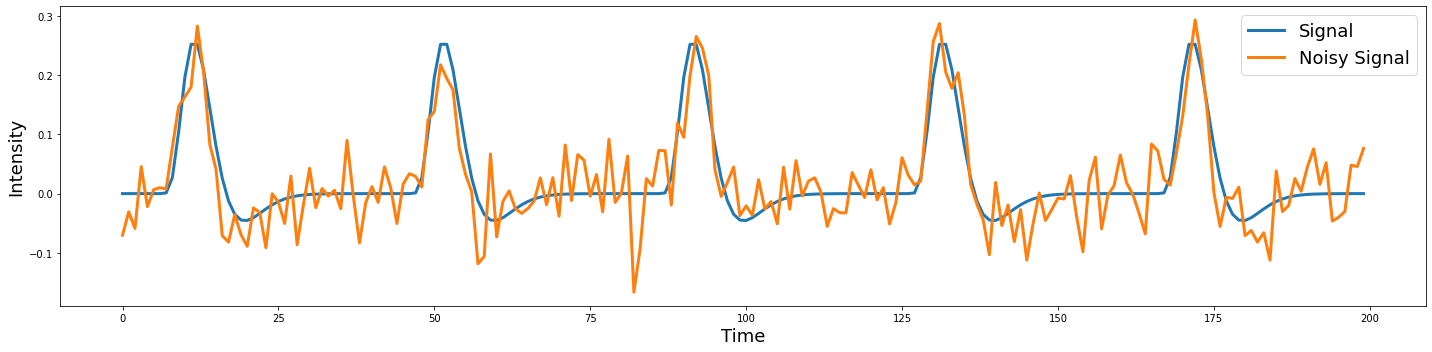

In [5]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import regress 
from nltools.external import glover_hrf
from scipy.stats import ttest_1samp

def plot_timeseries(data, linewidth=3, labels=None, axes=True):
    f,a = plt.subplots(figsize=(20,5))
    a.plot(data, linewidth=linewidth)
    a.set_ylabel('Intensity', fontsize=18)
    a.set_xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)
    if not axes:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        
def simulate_timeseries(n_tr=200, n_trial=5, amplitude=1, tr=1, sigma=0.05):
    y = np.zeros(n_tr)
    y[np.arange(20, n_tr, int(n_tr/n_trial))] = amplitude

    hrf = glover_hrf(tr, oversampling=1)
    y = np.convolve(y, hrf, mode='same')
    epsilon = sigma*np.random.randn(n_tr)
    y = y + epsilon
    return y

sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)
plot_timeseries(np.vstack([sim1,sim2]).T, labels=['Signal', 'Noisy Signal'])

Notice that the noise appears to be independent over each TR.

## Second level summary of between group variance¶

In the second level model, we are interested in relating the subject specific parameters contained in
to the population parameters . We assume that the first level parameters are randomly sampled from a population of possible regression parameters.

$\beta = X_g\beta_g+ŋ$

ŋ ~ Ŋ$(0, \sigma_g^2)$

Now let’s add noise onto the beta parameter to see what happens.



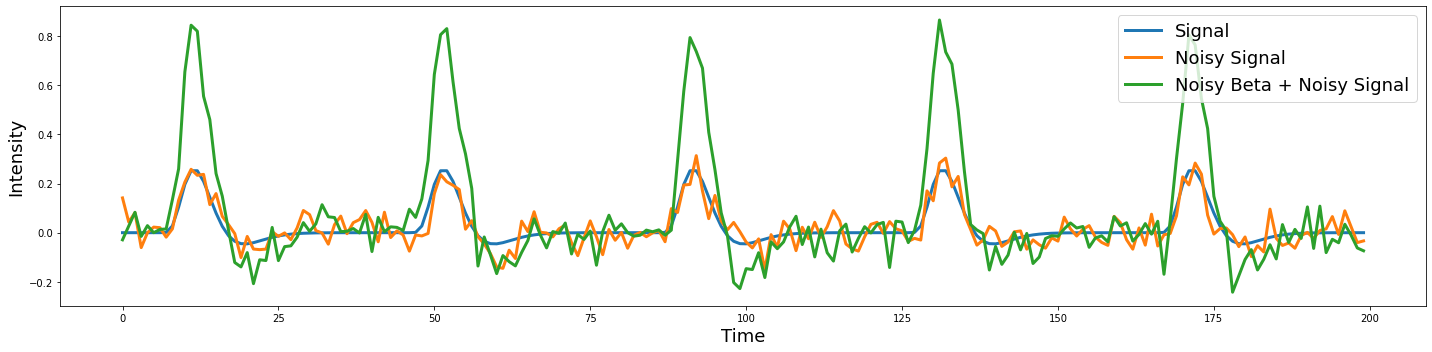

In [6]:
beta = np.abs(np.random.randn())*3
sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)
sim3 = simulate_timeseries(amplitude=beta, sigma=0.05)
plot_timeseries(np.vstack([sim1,sim2,sim3]).T, labels=['Signal', 'Noisy Signal', 'Noisy Beta + Noisy Signal'])

Try running the above code several times. Can you see how the beta parameter impacts the amplitude of each trial, while the noise appears to be random and uncorrelated with the signal?

Let’s try simulating three subjects with a beta drawn from a normal distribution.

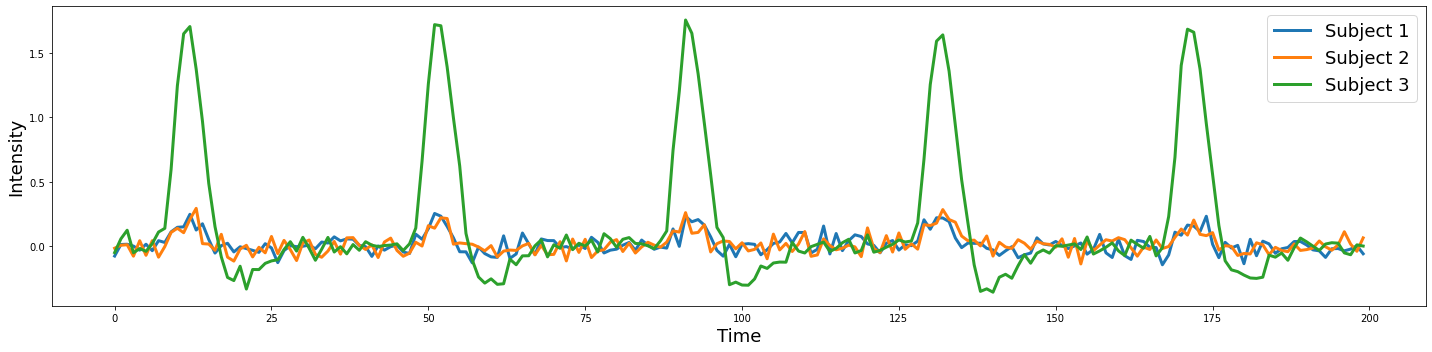

In [7]:
sim1 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim2 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim3 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
plot_timeseries(np.vstack([sim1, sim2, sim3]).T, labels=['Subject 1', 'Subject 2', 'Subject 3'])

To make an inference if there is a reliable difference within or across groups, we need to model the distribution of the parameters resulting from the first level model using a second level model. For example, if we were solely interested in estimating the average length men keep their hair, we would need to measure hair lengths from lots of different men and the average would be our best guess for any new male sampled from the same population. In our example, we are explicitly interested in the pairwise difference between males and females in hair length. Does the mean hair length for one sex significantly different from the hair length of the other group that is larger than the variations in hair length we observe within each group?

## Mixed Effects Model

In neuroimaging data analysis, there are two main approaches to implementing these different models. Some software packages attempt to use a computationally efficient approximation and use what is called a two stage summary statistic approach. First level models are estimated separately for every participant and then the betas from each participant’s model is combined in a second level model. This is the strategy implemented in SPM and is computationally efficient. However, another approach simultaneously estimates the first and second level models at the same time and often use algorithms that iterate back and forth from the single to the group. The main advantage of this approach over the two-stage approach is that the uncertainty in the parameter estimates at the first-level can be appropriately weighted at the group level. For example, if we had a bad participant with very noisy data, we might not want to weight their estimate when we aggregate everyone’s data across the group. The disadvantage of this approach is that the estimation procedure is considerably more computationally expensive. This is the approach implemented in FSL, BrainVoyager, and AFNI. In practice, the advantage of the true random effects simultaneous parameter estimation only probably benefits getting more reliable estimates when the sample size is small. In the limit, both methods should converge to the same answer. For a more in depth comparison see this [blog post by Eshin Jolly](https://eshinjolly.com/2019/02/18/rep_measures/).

A full mixed effects model can be written as,

$Y_i = X_i(X_g\beta_g+\eta) + \epsilon_i$

### OR

$Y$ ~ $(XX+g\beta_g,X\sigma^2_gX^T+\sigma^2)$

Let’s now try to recover the beta estimates from our 3 simulated subjects.

Text(0, 0.5, 'Estimated Beta')

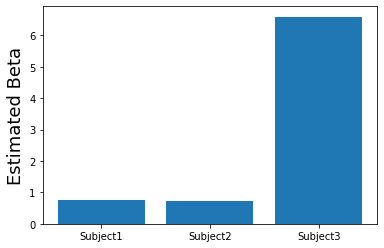

In [8]:
# Create a design matrix with an intercept and predicted response
task = simulate_timeseries(amplitude=1, sigma=0)
X = np.vstack([np.ones(len(task)), task]).T

#regress(X, sub)
# Loop over each of the simulated participants and estimate the amplitude of the response.
betas = []
for sub in [sim1, sim2, sim3]:
    beta,_,_,_,_,_ = regress(X, sub)
    betas.append(beta[1])

# Plot estimated amplitudes for each participant
plt.bar(['Subject1', 'Subject2', 'Subject3'], betas)
plt.ylabel('Estimated Beta', fontsize=18)

What if we simulated lots of participants? What would the distribution of betas look like?

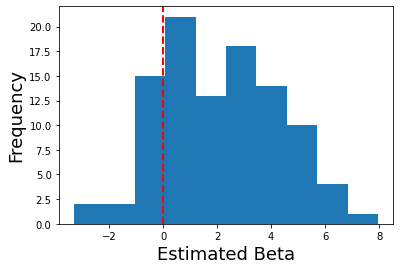

In [9]:
# Create a design matrix with an intercept and predicted response
task = simulate_timeseries(amplitude=1, sigma=0)
X = np.vstack([np.ones(len(task)), task]).T

# Loop over each of the simulated participants and estimate the amplitude of the response.
betas = []
for sub in range(100):
    sim = simulate_timeseries(amplitude=2+np.random.randn()*2, sigma=0.05)
    beta,_,_,_,_,_ = regress(X, sim)
    betas.append(beta[1])

# Plot distribution of estimated amplitudes for each participant
plt.hist(betas)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Estimated Beta', fontsize=18)
plt.axvline(x=0, color='r', linestyle='dashed', linewidth=2)

Now in a second level analysis, we are interested in whether there is a reliable effect across all participants in our sample. In other words, is there a response to our experiment for a specific voxel that is reliably present across our sample of participants?

We can test this hypothesis in our simulation by running a one-sample ttest across the estimated first-level betas at the second level. This allows us to test whether the sample has signal that is reliably different from zero (i.e., the null hypothesis).

In [10]:
ttest_1samp(betas, 0)

Ttest_1sampResult(statistic=9.214111177081353, pvalue=5.664320225267543e-15)

## Running a Group Analysis

Okay, now let’s try and run our own group level analysis with real imaging data using the Pinel Localizer data. I have run a first level model for the first 10 participants using the procedure we used in the single-subject analysis notebook.

Here is the code I used to complete this for all participants. I wrote all of the betas and also a separate file for each individual regressor of interest.

In [11]:
!pip install bids

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 3.8 MB/s 
     |████████████████████████████████| 125 kB 46.9 MB/s 
     |████████████████████████████████| 96 kB 3.0 MB/s 
     |████████████████████████████████| 1.3 MB 45.6 MB/s 
     |████████████████████████████████| 68 kB 3.9 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=d63e76b2bedaa9533a69cac079f12c4f27206ac895c9ca6ccf23841de429022f
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.41
    Uninstalling SQLAlchemy-1.4.41:
      Successfully uninstalled SQLAlchemy-1.4.41
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pi

In [12]:
!pip install nltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
import os
from glob import glob
import pandas as pd
import numpy as np
import nibabel as nib
from nltools.stats import zscore, regress, find_spikes
from nltools.data import Brain_Data, Design_Matrix
from bids import BIDSLayout, BIDSValidator
from nltools.file_reader import onsets_to_dm
from nltools.data import Brain_Data, Design_Matrix
from nilearn.plotting import view_img, glass_brain, plot_stat_map

data_dir = '/content/gdrive/MyDrive/localizer-data'
layout = BIDSLayout(data_dir, derivatives=True)


/usr/local/lib/python3.7/dist-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [15]:
tr = layout.get_tr()
fwhm = 6
spike_cutoff = 3

def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)


In [16]:
def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

In [17]:
#sub = 'S01'
localizer_path = '/content/gdrive/MyDrive/localizer-data'

for sub in layout.get_subjects(scope='derivatives'):
    #print(sub)
    #data = Brain_Data([x for x in layout.get(subject=sub, scope='derivatives', suffix='bold', extension='nii.gz', return_type='file') if 'denoised' not in x][0])
    #data = Brain_Data([x for x in layout.get(subject=f'sub-{sub}', scope='derivatives', suffix='bold', extension='nii', return_type='file') if 'denoised' not in x][0])
    #data = Brain_Data([x for x in os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz') if 'denoised' not in x][0])
    #data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
    #print(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
    #if os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'):
    #  data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
    #else:
    #  data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'))
    data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
      # so this seems to be the way to do it but it cant find a file and this doesnt make sense to me. I go in the file and it is there...? 

    #smoothed = data.smooth(fwhm=fwhm)

    #dm = load_bids_events(layout, sub)
    #covariates = pd.read_csv(layout.get(subject=sub, scope='derivatives', extension='.tsv')[0].path, sep='\t')
    #mc_cov = make_motion_covariates(covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']])
    #spikes = data.find_spikes(global_spike_cutoff=spike_cutoff, diff_spike_cutoff=spike_cutoff)
    #dm_cov = dm.convolve().add_dct_basis(duration=128).add_poly(order=1, include_lower=True)
    #dm_cov = dm_cov.append(mc_cov, axis=1).append(Design_Matrix(spikes.iloc[:, 1:], sampling_freq=1/tr), axis=1)
    #smoothed.X = dm_cov
    #stats = smoothed.regress()
    #file_name = layout.get(subject=sub, scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0]
    #stats['beta'].write(os.path.join(os.path.dirname(file_name), f"sub-{sub}_betas_denoised_{file_name.split('_')[1]}_{file_name.split('_')[2]}_smoothed{fwhm}_{file_name.split('_')[-1]}"))

    #for i, name in enumerate([x[:-3] for x in dm_cov.columns[:10]]):
    #    stats['beta'][i].write(os.path.join(os.path.dirname(file_name), f"sub-{sub}_{name}_denoised_{file_name.split('_')[2]}_smoothed{fwhm}_{file_name.split('_')[-1]}"))



FileNotFoundError: ignored

In [19]:

localizer_path = '/content/gdrive/MyDrive/localizer-data'

for sub in layout.get_subjects(scope='derivatives'):
  if os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'):
    data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
  else:
    data = Brain_Data(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'))

# This loop wont loop for some reason.... I am not sure why... 
# it should wrok but it only gives me an error on teh ef without trying the else



FileNotFoundError: ignored

In [18]:
for i in layout.get_subjects(scope='derivatives'):
  if i == 'S47':
    print(i)
  else:
    print("nope")

S47
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope


In [20]:
for sub in layout.get_subjects(scope='derivatives'):
  if os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'):
    print(sub)
  else:
    print("nope")

S47
S68
S35
S16
S15
S69
S63
S30
S83
S58
S40
S81
S44
S42
S88
S22
S87
S92
S93
S11
S80
S20
S84
S56
S57
S82
S64
S26
S09
S38
S90
S24
S36
S76
S70
S43
S25
S46
S45
S34
S05
S10
S37
S65
S27
S75
S02
S39
S12
S66
S06
S86
S62
S67
S72
S53
S28
S03
S31
S73
S29
S48
S18
S04
S21
S07
S71
S55
S94
S91
S19
S14
S78
S52
S32
S17
S13
S85
S51
S50
S61
S74
S41
S01
S49
S54
S89
S23
S08
S60
S33
S77
S79
S59


In [21]:
myfiles = []
for sub in layout.get_subjects(scope='derivatives'):
  if os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'):
    myfiles.append(os.path.join(localizer_path,"derivatives","fmriprep", f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
  else:
    myfiles.append("nope")

In [22]:
myfiles
# every single participant has this nii.gz file already.... WTF

['/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S47/func/sub-S47_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S68/func/sub-S68_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S35/func/sub-S35_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S16/func/sub-S16_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S15/func/sub-S15_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S69/func/sub-S69_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S63/func/sub-S63_task-locali

In [23]:
for i in myfiles:
  data = Brain_Data(i)

FileNotFoundError: ignored

sub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

In [48]:
data = Brain_Data('/content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S59/funcsub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

FileNotFoundError: ignored

In [ ]:
layout.get_subjects(scope='derivatives')

sub-S47_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii

sub-S36_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

In [36]:
!ls /content/gdrive/MyDrive/localizer-data/derivatives/fmriprep/sub-S59/func

sub-S59_task-localizer_desc-confounds_regressors.json
sub-S59_task-localizer_desc-confounds_regressors.tsv
sub-S59_task-localizer_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.json
sub-S59_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Now, we are ready to run our first group analyses!

Let’s load our design matrix to remind ourselves of the various conditions

## One Sample t-test

For our first group analysis, let’s try to examine which regions of the brain are consistently activated across participants. We will just load the first regressor in the design matrix - horizontal_checkerboard.

We will use the glob function to search for all files that contain the name horizontal_checkerboard in each subject’s folder. We will then sort the list and load all of the files using the Brain_Data class. This will take a little bit to load all of the data into ram.